Set working directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import logging

# Change file_path as necessary
file_path = "../" 

os.chdir(file_path)

Load files

In [5]:
def identify_type_of_day(date):
    weekno = date.weekday()
    if((date.month == 7 and week_of_month(date) < 4 ) or (date.month == 12 or date.month == 1 or date.month == 2)):
        return 'Major_study_break'
    elif weekno>5:
        return 'Weekend'
    elif is_public_holiday(date):
        return 'Public_holiday'
    else:
        return 'Study_period_day'

#Week of month
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

#Returns True if it's  public holiday
def is_public_holiday(dt):
    public_holidays =  pd.read_csv('australianpublicholidays.csv', sep=',', encoding='ISO-8859-1', parse_dates=['Date'],
                 date_parser=lambda x: pd.to_datetime(x))
    """"Instead API could be used : import urllib
    url = 'https://data.gov.au/api/3/action/datastore_search?resource_id=253d63c0-af1f-4f4c-b8d5-eb9d9b1d46ab&limit=5&q=title:jones'  
    fileobj = urllib.urlopen(url)
    print fileobj.read() """
    
    #get public holidays of SA only
    public_holidays_SA = public_holidays[public_holidays['Applicable To'].str.contains("SA")]
    
    #Return True if each date is public holiday in SA
    return dt in public_holidays_SA['Date'].apply(lambda x: datetime.date(x))


In [7]:
def add_day_type_column(file, date_column):
    data_file = pd.read_csv(file, sep=',', encoding='ISO-8859-1', parse_dates=[date_column],
                 date_parser=lambda x: pd.to_datetime(x.rsplit(' ', 1)[0]))
    data_file['Type_of_day'] = data_file[date_column].apply(lambda x: identify_type_of_day(x))
    file_name = file + 'with_day_type.csv'
    #data_file.to_csv(file_name, sep=',', encoding='utf-8')
    return data_file


In [40]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# ### estimate campus power
# 
# The bulk of the data is for kVA values. Estimated the real power drawn from this based on the mean power factor for the data we did have. 

# In[8]:

def campus_power_estimation(bms):
    """Estimate real power form kVA value based on average pf of the 
        small set of paired values we do have
    """
    
    #bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'] / bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kVA (kVA)']

   #if logger.getEffectiveLevel() < logging.INFO: 
        #plt.scatter(bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'], 
         #           bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['kVA'], 
          #          alpha=0.05)
        #plt.title('Power factor scatter plot.'); 
        #plt.show()
    
    bms['kW_est'] = bms['kVA'] * 0.92
    # use original values where I have them: 
    bms['kW_est'] = np.where(bms['kW'] == 0.0, bms['kW_est'], bms['kW'])
    bms.kW_est = bms.kW_est.where(bms.kW_est >= 0, 0.0)
    return bms
    
def kva_to_kw(bms):
    """Estimate real power form kVA value based on average pf of the 
        small set of paired values we do have
    """

    #= bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'] / bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kVA (kVA)']
    
    bms['kW_est'] = bms['kVA'] * 0.92
    # use original values where I have them: 
    #bms.kW_est = bms.kW_est.where(bms.kW_est >= 0, 0.0)
    return bms
    

In [14]:
#replace zero's with previous year values
def replace_zeros(bms,bms_lastyear):
    #check for day to day relation instead
    return bms.where(bms['kVA'] != 0, bms_lastyear['kVA'],axis=0)
    

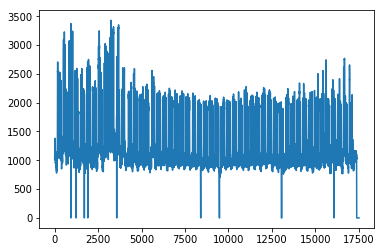

In [27]:
#2016 demand plotline
bms_demand_2016 = add_day_type_column('bms_2016.csv','?Timestamp')
bms_demand_2016.rename(columns={'?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
bms_demand_2016['kVA'].plot.line()

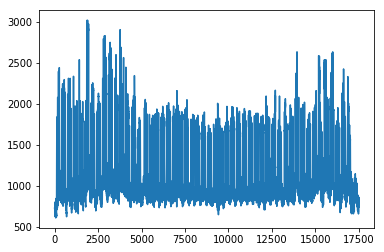

In [46]:
bms_demand_2017 = add_day_type_column('bms_2017_kva.csv','?Timestamp')
bms_demand_2017.rename(columns={'ML_PH/Main_11kV_kW (kW)': 'kW','?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
bms_demand_2017['kW'].plot.line()

#imputed kva's plot line (replaced from last year values)
bms_2017_imputed = replace_zeros(bms_demand_2017_est, bms_demand_2016)
#bms_2017_imputed['kVA'].plot.line()

#Estimate kW using kVA if kW values not recorded
bms_demand_2017_est = campus_power_estimation(bms_2017_imputed)
bms_demand_2017_est['kW_est'].plot.line()

grouped_by_daytype = bms_demand_2017_est.groupby(['Type_of_day'])['kVA'].mean()
grouped_by_daytype.plot.bar()


In [ ]:
# change scale of humidity and temperature
bms_transformed = bms_kw_est[['TimeStamp','kW_est', 'Type_of_day','Humidity','Temp']].copy()
bms_transformed['Humidity'] = bms_transformed['Humidity'].apply(lambda x: x*10)
bms_transformed['Temp'] = bms_transformed['Temp'].apply(lambda x: x*10)
bms_transformed.loc[5000:7000].plot(x='TimeStamp', y=['kW_est','Humidity','Temp'] ,figsize=(20,10), grid=True  )

In [ ]:
#Check correations among attributes
corr_val = bms_kw_est.corr()
print (corr_val)
import seaborn as sns
sns.heatmap(corr_val, 
        xticklabels=corr_val.columns,
        yticklabels=corr_val.columns)

In [ ]:
#interctive graphs - work in progress
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go

In [ ]:
pv = pd.pivot_table(bms_kw_est, index=['Name'], columns=["Status"], values=['Quantity'], aggfunc=sum, fill_value=0)

In [ ]:
trace1 = go.Bar(x=bms_kw_est.TimeStamp, y=bms_kw_est[('Quantity', 'declined')], name='Declined')
trace2 = go.Bar(x=pv.index, y=pv[('Quantity', 'pending')], name='Pending')
trace3 = go.Bar(x=pv.index, y=pv[('Quantity', 'presented')], name='Presented')
trace4 = go.Bar(x=pv.index, y=pv[('Quantity', 'won')], name='Won')

In [ ]:
#test
today = datetime.today()
today.weekday()

In [ ]:
#Comparing distributions
bms_kw_est['kW_est'].plot.line()

#2017 demand estimate for all kva plot line
bms_all.rename(columns={'?Timestamp': 'TimeStamp','ML_PH/Main_11kV_kVA (kVA)' : 'kVA','ML_PH/PH_Ambient_Temperature (°C)':'Temp','ML_PH/PH_Ambient_Humidity (%RH)': 'Humidity'}, inplace=True)
bms_2017 = kva_to_kw(bms_all)
bms_2017['kW_est'].plot.line()



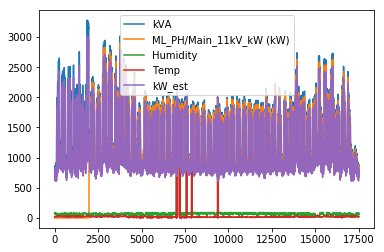

In [24]:
#arma model
import statsmodels.api as sm

res = sm.tsa.ARMA(bms_2017_imputed['kVA'], (3, 0)).fit(disp=0)
res
fig, ax = plt.subplots()
ax = bms_2017_imputed.plot(ax=ax)
#res.plot_predict('1990', '2012', dynamic=True, ax=ax,
#                 plot_insample=False)
